# IO


In this lab you will be testing different IO strategies and their impact on performance. I will provide code snippets on how to read and write to different devices.Your job is to use these code blocks to write a testing suite that tests compares the effect of different reading and writing strategies.

## Getting started

You will need to do this lab on the SLURM cluster. Begin by loging in through Chrome Remote Desktop. Then request exclusive access to one of the compute nodes with X11 support

srun  --x11 --pty --exclusive  -p cpu  /bin/bash 

Activate the python environment in spack 

spack load python

Next clone the repository for the lab and open up this notebook

git clone http://zapad.stanford.edu/GP257/io-lab.git

jupyter notebook notebook.ipynb

Lets begin by creating a large 3-D array in numpy and use the cosine function to create some intersting patterns.

In [1]:
import numpy as np
import math
import numba

def createData(n1,n2,n3,n1max=math.pi*3,n2max=math.pi*3,n3max=math.pi*3):
    """
        A function to create interesting looking data
        
        n1,n2,n3 - The size of the array
        n1max,n2max,n3max - The range of each axis. Larger results in more cycles
    """
    x=np.cos(np.linspace(0,n1max,n1))
    y=np.cos(np.linspace(0,n2max,n2))
    z=np.cos(np.linspace(0,n3max,n3))
    ar=np.zeros((n3,n2,n1))
    for i3 in range(n3):
        for i2 in range(n2):
            for i1 in range(n1):
                ar[i3,i2,i1]=z[i3]+y[i2]+x[i1]
    return ar    

The next cell is going to take significant time. You could always rewrite the loop above in numba speed it up. Meshgrid could also be used but it might take up quite a bit of memory if you aren't careful.

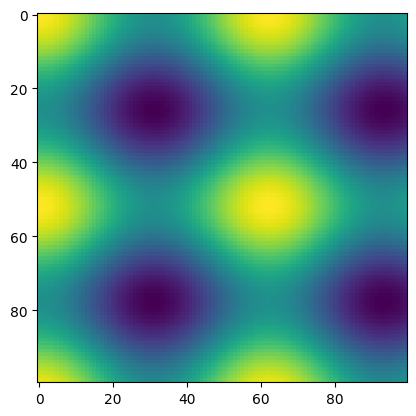

In [3]:
import matplotlib.pyplot as plt

n1 = 100
n2 = 100
n3 = 100

array=createData(n1,n2,n3,10,12,3)
plt.imshow(array[90,:,:])

In [4]:
array.shape

(100, 100, 100)

Below are functions to open files on the three (might want to add ssd) different memory devices that have different properties. The first is the local file system ("/tmp"), the second is a NFS filesystem ("/home"), the third is an object storage system. In each case we will return a handler that we will use for writing.

In [5]:
import os
from google.cloud import storage 

#name of files/objects we are going to use
user=os.environ["USER"]
tmpFile=f"/tmp/{user}_destroy"
homeFile=f"/home/scratch/{user}_destroy"
object="{user}/destroy"
bucketName="scratch-sep"

#open a file on tmp for read or write
def openLocalRead():
    return open(tmpFile,"rb")

def openLocalWrite():
    return open(tmpFile,"wb")

#open a file on home for read or write
def openNFSRead():
    return open(homeFile,"rb")

def openNFSWrite():
    return open(homeFile,"wb")

#open object
def openObjectRead():
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucketName)
    blob = bucket.blob(object)
    if not blob.isok():
        raise Exception("Trouble creating blob")
    return blob.open("rb")

def openObjectWrite():
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucketName)
    blob = bucket.blob(object)
    return blob.open("wb")


You can use these functions to open different devices that you can write to. Next lets build a series of functions that will read or write a portion our data arrays.

In [86]:
def writeData(fle,array,b1,b2,b3,e1,e2,e3):
    """
      fle - File handlear
      array - Array to read/write to
      b1,b2,b3 - Begin index
      e1,e2,e3 - End index
      
      Note we are making a big assumption of sequential writes
    
    """
    x=array[b3:e3,b2:e2,b1:e1].tobytes()
    fle.write(x)
    
    
def readData(fle,array,b1,b2,b3,e1,e2,e3):
    """
        fle - File handle
        array - Array to read into
        b1,b2,b3 -Begin index 
        e1,e2,e3 - End index
        
        
        Note: We are making a big assumnption of sequential reads
    """
    shape1 = np.max([1, e3-b3-1])
    shape2 = np.max([1, e2-b2-1])
    shape3 = np.max([1, e1-b1-1])

    array[b3:e3,b2:e2,b1:e1]=np.frombuffer(fle.read((e3-b3-1)*n1*n2*8  + (e2-b2-1)*n1*8 + (e1-b1-1)*8 ),dtype=array.dtype).reshape(shape1,shape2,shape3)


We can use these functions to write the data to our different storage choices.

In [87]:
tmpF=openLocalWrite()
writeData(tmpF,array,0,0,0,array.shape[2],array.shape[1],array.shape[0])
tmpF.close()

tmpN=openNFSWrite()
writeData(tmpN,array,0,0,0,array.shape[2],array.shape[1],array.shape[0])
tmpN.close()

# # the follwing code does not work
# tmpB=openObjectWrite()
# writeData(tmpB,array,0,0,0,array.shape[2]*200,array.shape[1],array.shape[2])
# tmpB.close()

## What you need to do (pt1)

Using the functions above and what you have learned about timers perform a series of timing tests. In each case you are going read or write the entire dataset in a loop. What is going to change is how much you read or write at a time. Vary the size of your blocks approximately logrthymically staring at 50 samples. Make a chart of performance vs blocksize.

In [96]:
import time 

# Test the speed for IO using different block sizes
n1 = 100
n2 = 100
n3 = 100
max_size = n1*n2*n3
min_size = 50

time_local_write = []
time_local_read = []


for block_size in range(2, 10, 10):
   
    # generate block sizes
    blocks = np.logspace(np.log10(min_size+0.01), np.log10(max_size), num=block_size, endpoint = True, dtype=int)

    # record time 
    start_time = time.time()
    
    # open file
    tmpF=openNFSWrite()

    # loop over blocks and write data
    b1, b2, b3 = 0, 0, 0
    for block in blocks:
        # get the data index for current block size
        e1 = block % n1
        e2 = (block % (n1 * n2)) // n1
        e3 = block // (n1 * n2)
        print(b1, b2, b3, e1, e2, e3)
        # write data with patch
        writeData(tmpF, array, b1, b2, b3, e1+1, e2+1, e3+1)
        b1, b2, b3 = e1, e2, e3
    tmpF.close()
    time_local_write.append(time.time() - start_time)
    
    # record time 
    start_time = time.time()
    
    # open file
    tmpF=openNFSRead()

    # loop over blocks and write data
    b1, b2, b3 = 0, 0, 0
    for block in blocks:
        # get the data index for current block size
        e1 = block % n1
        e2 = (block % (n1 * n2)) // n1
        e3 = block // (n1 * n2)
        # write data with patch
        readData(tmpF,array,b1,b2,b3,e1+1,e2+1,e3+1)
        b1, b2, b3 = e1, e2, e3
    tmpF.close()
    time_local_read.append(time.time() - start_time)
    


0 0 0 50 0 0
50 0 0 0 0 100


ValueError: could not broadcast input array from shape (1,1,50) into shape (1,1,51)

In [109]:
    index1 = slice(b1, e1)
    index2 = slice(b2, e2)
    c = slice(b3, e3)

In [111]:
index3

slice(0, 1, None)

In [100]:
b1,b2,b3,e1,e2,e3 = 0, 0, 0, 50+1, 0+1, 0+1

shape1 = np.max([1, e3-b3-1])
shape2 = np.max([1, e2-b2-1])
shape3 = np.max([1, e1-b1-1])

=np.frombuffer(tmpF.read((e3-b3-1)*n1*n2*8  + (e2-b2-1)*n1*8 + (e1-b1-1)*8 ),dtype=array.dtype).reshape(shape1,shape2,shape3)


ValueError: cannot reshape array of size 1 into shape (1,1,50)

In [104]:
(e3-b3-1)*n1*n2*8  + (e2-b2-1)*n1*8 + (e1-b1-1)*8

400

In [105]:
# open file
tmpF=openNFSRead()

In [106]:
np.frombuffer(tmpF.read((e3-b3-1)*n1*n2*8  + (e2-b2-1)*n1*8 + (e1-b1-1)*8 ),dtype=array.dtype).reshape(shape1,shape2,shape3)

array([[[3.        , 2.99490282, 2.97966323, 2.95443659, 2.91948007,
         2.87515004, 2.8218984 , 2.76026803, 2.69088721, 2.61446323,
         2.53177518, 2.44366602, 2.35103397, 2.25482335, 2.15601496,
         2.0556161 , 1.95465027, 1.85414675, 1.75513011, 1.65860977,
         1.56556968, 1.47695834, 1.39367908, 1.31658087, 1.24644969,
         1.18400048, 1.12986988, 1.08460969, 1.04868134, 1.02245107,
         1.0061863 , 1.00005283, 1.0041132 , 1.018326  , 1.04254634,
         1.07652732, 1.11992252, 1.17228956, 1.23309458, 1.30171771,
         1.3774594 , 1.45954749, 1.54714515, 1.63935939, 1.73525012,
         1.83383982, 1.93412341, 2.03507857, 2.13567613, 2.23489055]]])

In [107]:
shape1,shape2,shape3

(1, 1, 50)

In [108]:
k = array[b3:e3,b2:e2,b1:e1]
k.shape

(1, 1, 51)

In [89]:
# open file
tmpF=openNFSWrite()
writeData(tmpF, array, 0,0,0, 0+1, 100+1, 100+1)

tmpF.close()
# time_local_write.append(time.time() - start_time)

In [90]:
array[0:1,:10000,0:100].shape

(1, 100, 100)

In [91]:
array.shape

(100, 100, 100)

In [92]:
tmpF=openNFSRead()
array_new = np.zeros((100, 100, 100))
readData(tmpF,array_new, 0,0,0,0+1,100+1, 100+1)

tmpF.close()

In [93]:
array_new

array([[[3.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [2.9926628 , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [2.97075887, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [2.6903708 , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [2.77278244, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [2.84385396, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[2.9995409 , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [2.9922037 , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [2.97029977, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [2.6899117 , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [2.7

In [ ]:
array[b3:e3,b2:e2,b1:e1]=np.frombuffer(fle.read(,dtype=array.dtype)

In [ ]:
time_nfs_write = []
time_nfs_read = []

time_object_write = []
time_object_read = []

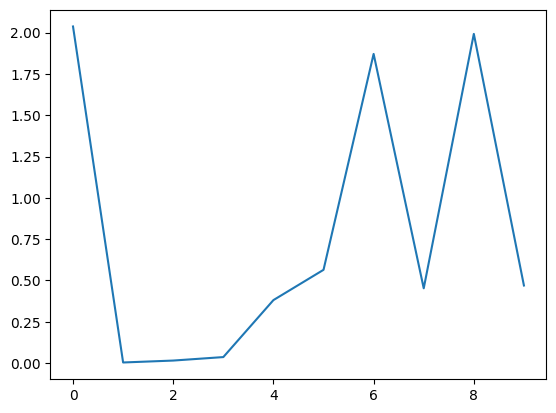

In [35]:
for block_num in range(2, 100, 10):
    print(block_num)

2
12
22
32
42
52
62
72
82
92


## What you need to do (pt2)

You have learned that parallelism is useful.  Modify the functions above so you are writing to different files/objects and use what you have learned about the multiprocessing module to write the blocks to different files. Star with the assumption that anything smaller than 1MB is probably sub-optimail.  
Hint: You might need to look at the second multiprocessing lab.

## Going beyond (optional)

Data is often compressible. Take a look at https://computing.llnl.gov/projects/zfp. Assuming some tollerance error add in compression/decompression and compare.


## Finishing up


Summarize what you learned in this lab. How does it effect your code design in the future?